# Capstone Project for NYC Data Science Academy

## Natural Language Processing: Recipe Recommendation Engine



### Questions:

1. Why use directions text instead of ingredients list?
2. Is there anything specific we need to consider since our text sample is on a restricted topic?

### Ideas:

1. Use title words to classify as dessert
2. Use title words to weight ingredients
3. In addition to missing ingredients - propose substitutions?
4. Word cloud groupings to describe the group and user can choose which sounds most like what they are looking for
    -Or we could do Topic clustering for an upper level 'dinner, side, breakfast, dessert' and then iterate within each category? Dinner: chicken, beef, pork, seafood, vegetarian etc. Continue on to mediterranean, french, mexican, etc.

### Reading in Data and Examining

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import texthero as hero
from texthero import stopwords
import os
from wordcloud import WordCloud
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob,Word

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jamesreno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('dataset/full_dataset.csv')

In [3]:
df.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


### Identifying website source for each recipe

In [35]:
test_=[]

for i in df['link']:
    test_.append(i[0:re.search('.com',i).span()[1]])

In [39]:
df['website_used']=test_

In [40]:
df.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER,website_used
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu...",www.cookbooks.com
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom...",www.cookbooks.com
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar...",www.cookbooks.com
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo...",www.cookbooks.com
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu...",www.cookbooks.com


In [41]:
df['website_used'].value_counts()

www.cookbooks.com          896341
www.food.com               499616
www.epicurious.com         129444
tastykitchen.com            78768
www.myrecipes.com           64895
www.allrecipes.com          61398
cookpad.com                 61020
cookeatshare.com            59307
www.yummly.com              51963
www.tasteofhome.com         51594
www.foodnetwork.com         49443
food52.com                  48501
www.kraftrecipes.com        42010
recipeland.com              24418
recipes-plus.com            20524
cooking.nytimes.com         16367
www.foodandwine.com         15436
www.seriouseats.com         12632
www.foodgeeks.com            8963
www.cookstr.com              8797
online-cookbook.com          5691
www.chowhound.com            5671
www.vegetariantimes.com      4578
www.delish.com               3880
allrecipes.com               3204
www.landolakes.com           2492
www.foodrepublic.com         2259
www.lovefood.com             1930
Name: website_used, dtype: int64

### Taking a Sample

In [55]:
df_sample = df.sample(n=10000,ignore_index=True,random_state=422)

### Preprocessing and Cleaning

Taken from this [article](https://medium.com/geekculture/data-preprocessing-and-eda-for-natural-language-processing-56e45c1df36d). Code was run as is and then modified heavily to suit our purposes.

In [59]:

def lemma_per_pos(sent):
    '''function to lemmatize according to part of speech tag'''
    t = TextBlob(sent)
    t_dict = {"J": 'a',"N": 'n',"V": 'v',"R": 'r'}
    w_n_t = [(w, t_dict.get(p[0], 'n')) for w, p in t.tags]
    lemmatized_list = [w.lemmatize(t) for w, t in w_n_t]
    return " ".join(lemmatized_list)
def df_preprocessing(df,col_name,new_col_name):
    default_stopwords = stopwords.DEFAULT
   # adding some stop words as for movie review,so removing it
   #custom_stopwords = default_stopwords.union(set(["movie","film"]))
    df[new_col_name]=[text.replace('\\u00b0','') for text in df[col_name]]
   # cleaning
    df[new_col_name]= (
              df[new_col_name]
              .pipe(hero.clean)
              .pipe(hero.remove_html_tags))
#               .pipe(hero.remove_brackets)
#               .pipe(hero.remove_urls))
    # lemmatization
    df[new_col_name]= [lemma_per_pos(sent) for sent in df[new_col_name]]
    df[new_col_name]=hero.remove_stopwords(df[new_col_name],default_stopwords)
    return df

In [174]:
#taken from https://medium.com/geekculture/data-preprocessing-and-eda-for-natural-language-processing-56e45c1df36d
def df_preprocessing(df,col_name,new_col_name):
    default_stopwords = stopwords.DEFAULT
   # adding some stop words as for movie review,so removing it
   #custom_stopwords = default_stopwords.union(set(["movie","film"]))
    df[new_col_name]=[text.replace('\\u00b0','') for text in df[col_name]]
   # cleaning
    df[new_col_name]= (
              df[new_col_name]
              .pipe(hero.clean)
              .pipe(hero.remove_html_tags))
    df[new_col_name]=hero.remove_stopwords(df[new_col_name],default_stopwords)
    
    # lemmatization
#     lemmatizer = WordNetLemmatizer()
    
    
     '''The author of the article restricted POS and lemmatized according to new assignments.
        This didn't seem particularly helpful in our use case, so I used another technique also introduced in the
        article. This performed better by identifying words like bananas as a plural of banana instead of a verb.'''
    df[new_col_name]= df[new_col_name].apply(lambda x: \
                                             [lemmatizer.lemmatize(w) for w in x.split()])
    
    return df

In [175]:
df_preprocessing(df_sample,'directions','clean_directions')

,Unnamed: 0,title,ingredients,directions,link,source,NER,clean_directions
0,2053585,Eggplant Squash Masala,"[""1 small onion, chopped"", ""2 tablespoons oliv...","[""In a large skillet, saute the onion in the o...",www.food.com/recipe/eggplant-squash-masala-407841,Recipes1M,"[""onion"", ""olive oil"", ""turmeric"", ""garam masa...","[large, skillet, saute, onion, olive, oil, oni..."
1,1104000,"Oreo Cookie "" Cakester"" Cake","[""1 (18 1/4 ounce) package devil's food cake m...","[""For the cake; prepare and bake the cake acco...",www.food.com/recipe/oreo-cookie-cakester-cake-...,Gathered,"[""cake mix"", ""CREAM FILLING"", ""cream cheese"", ...","[cake, prepare, bake, cake, according, package..."
2,82615,Sausage And Cheese Bake,"[""1 (8 oz.) can refrigerated crescent dinner r...","[""Heat oven to 400\u00b0."", ""Separate rolls in...",www.cookbooks.com/Recipe-Details.aspx?id=559835,Gathered,"[""rolls"", ""sausage"", ""shredded Monterey Jack c...","[heat, oven, separate, roll, large, rectangle,..."
3,1965027,Japanese Soba With Dipping Sauce,"[""4 spring onions, finely chopped"", ""1 sheet n...","[""Note: the recipes calls for kezuri-bushi but...",www.food.com/recipe/japanese-soba-with-dipping...,Recipes1M,"[""spring onions"", ""noodles"", ""wasabi paste"", ""...","[note, recipe, call, kezuri, bushi, zaar, comp..."
4,1771343,Cheesecake Ice Cream,"[""8 ounces (230 g) cream cheese"", ""1 lemon, pr...","[""Cut the cream cheese into small pieces."", ""Z...",www.epicurious.com/recipes/food/views/cheeseca...,Recipes1M,"[""cream cheese"", ""lemon"", ""sour cream"", ""sugar...","[cut, cream, cheese, small, piece, zest, lemon..."
...,...,...,...,...,...,...,...,...
9995,1872195,Creamy Macaroni And Cheese Bake Recipe,"[""2 c. cooked elbow macaroni"", ""1/3 c. mayonna...","[""Combine macaroni with mayonnaise and onion.""...",cookeatshare.com/recipes/creamy-macaroni-and-c...,Recipes1M,"[""macaroni"", ""mayonnaise"", ""onion"", ""cream of ...","[combine, macaroni, mayonnaise, onion, blend, ..."
9996,2225718,Easy Crepes Suzette,"[""2 oranges Safeway 1 lb For $0.79 thru 02/09""...","[""GRATE rind from oranges and measure 1 Tbsp (...",www.kraftrecipes.com/recipes/easy-crepes-suzet...,Recipes1M,"[""oranges"", ""Cream Cheese"", ""Orange Marmalade""...","[grate, rind, orange, measure, tbsp, ml, secti..."
9997,595787,Barbecups,"[""1 lb. ground beef (or leftover barbecue meat...","[""Heat"", ""oven"", ""to\t400\u00b0."", ""In"", ""larg...",www.cookbooks.com/Recipe-Details.aspx?id=160788,Gathered,"[""ground beef"", ""barbecue sauce"", ""onion"", ""br...","[heat, oven, \t400, large, skillet, brown, gro..."
9998,465060,Grasshopper Pie(Serves 8),"[""24 Oreos, crushed"", ""1/2 c. butter, melted"",...","[""Mix cookies and butter."", ""Press into bottom...",www.cookbooks.com/Recipe-Details.aspx?id=724871,Gathered,"[""Oreos"", ""butter"", ""marshmallows"", ""creme"", ""...","[mix, cooky, butter, press, bottom, side, inch..."


#### Trying out NLTK's frequency distribution on the words present

In [176]:
temp_words=[]
for i in range(0,len(df_sample['clean_directions'])):
    temp_words += df_sample['clean_directions'][i]

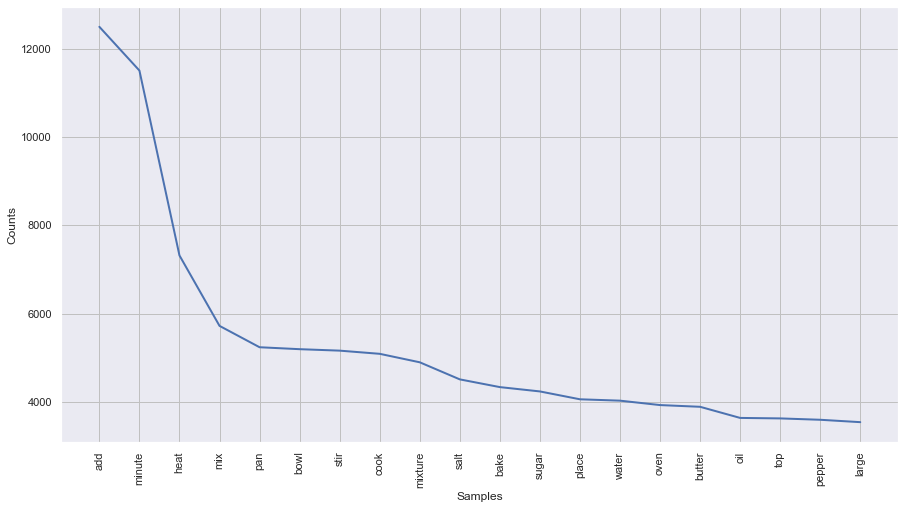

In [178]:
sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(temp_words)
nlp_words.plot(20);

#### Collecting word frequency numbers continuing to follow the article

In [179]:
word_freq= {}
for word in set(temp_words):
    word_freq[word]= temp_words.count(word)
#Creating dataframe of words
df_word= pd.DataFrame(word_freq.items(),columns=['word','count'])

In [180]:
df_word['word_len']= df_word['word'].map(lambda x: len(x))
# sorting values 
df_word=df_word.sort_values('count',ascending=False).reset_index(drop=True)
df_word

,word,count,word_len
0,add,12494,3
1,minute,11503,6
2,heat,7315,4
3,mix,5720,3
4,pan,5236,3
...,...,...,...
8821,moistend,1,8
8822,1cup,1,4
8823,elongated,1,9
8824,peppeer,1,7


<AxesSubplot:xlabel='count', ylabel='word'>

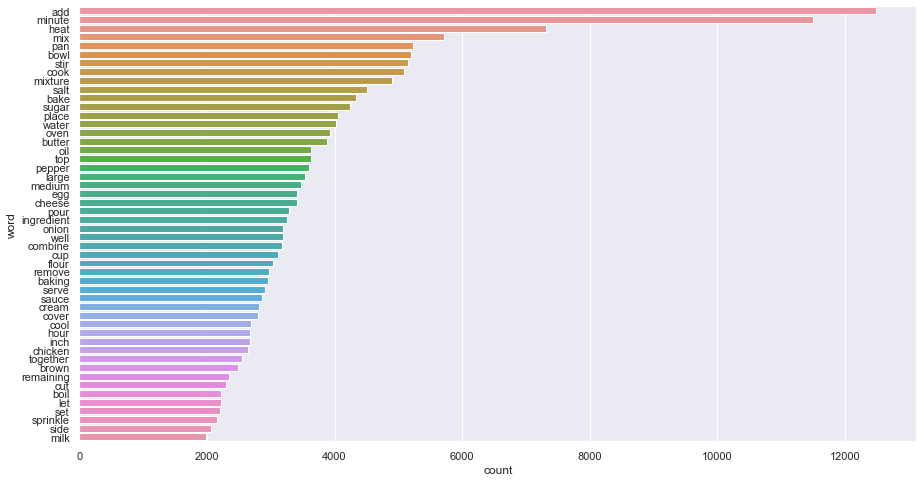

In [181]:
df_top = df_word.head(50)

sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x=df_top['count'],y=df_top['word'])

<AxesSubplot:>

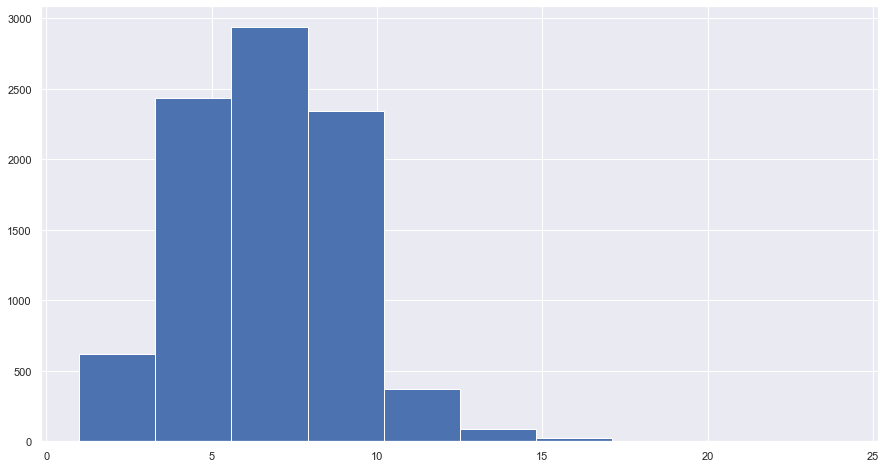

In [182]:
df_word['word_len'].hist()

In [183]:
df_word[df_word['word_len']==max(df_word['word_len'])]

,word,count,word_len
7226,sheet\r\n\r\nalternately,1,24


#### Started to explore ngrams

[Source](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools)

In [197]:
import matplotlib as plt

In [198]:
from nltk.util import ngrams

In [203]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

In [218]:
def get_top_ngram(corpus,n=None):
    vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                 for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[0:50]

In [214]:
# necessary code to join the separated words above into a single string for use in "get_top_ngram" function
df_sample['clean_dir_one']= df_sample['clean_directions'].apply([lambda x: ' '.join(x)])

In [219]:
top_n_bigrams = get_top_ngram(df_sample['clean_dir_one'],2)

<AxesSubplot:>

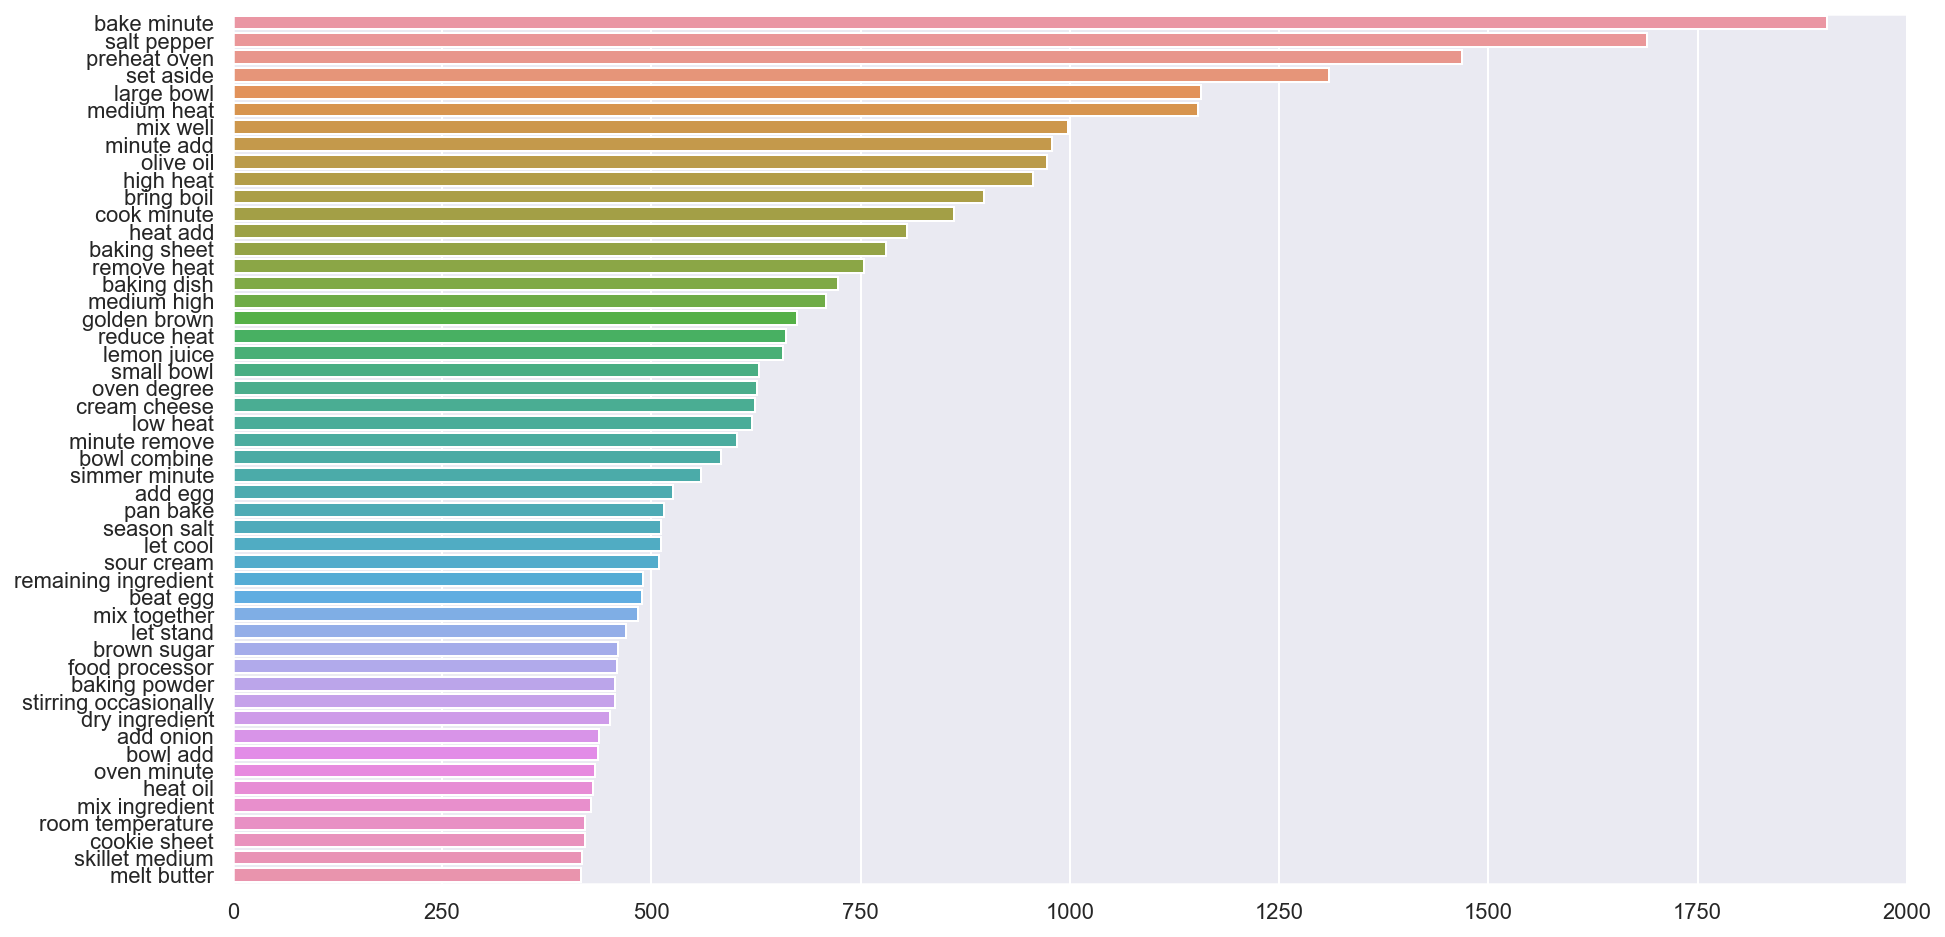

In [220]:
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

#### Notes
Considered removing verbs from the directions column to make bigrams more meaningful. Many of the bigrams above include verbs that wouldn't necessarily help someone identify recipes based on ingredients.

POS tagging seemed to be mislabeling many words in the directions column. So I decided to switch to the ingredients list for more accurate part of speech tagging.
Removed numbers, measurement terms, verbs, adverbs

# Final version of the preprocessing functions

In [286]:
#taken from https://medium.com/geekculture/data-preprocessing-and-eda-for-natural-language-processing-56e45c1df36d
def remove_by_pos(sent):
    '''function to remove words according to part of speech tag'''
    words_retained=[]
    t = TextBlob(sent)
    for word, pos in t.tags:
        if (pos[0]!='V' and pos[0]!='R'):
            words_retained.append(word)
    
    return " ".join(words_retained)

def df_preprocessing(df,col_name,new_col_name):
    default_stopwords = stopwords.DEFAULT
   # adding some stop words as for measurements
    custom_stopwords = default_stopwords.union(set(["ingredient","cup","tablespoon","teaspoon","ounce","oz","tsp",\
                                                    "tbs", "pound","lb","c"]))
    df[new_col_name]=[text.replace('\\u00b0','') for text in df[col_name]]
    
    #removing words by POS
    df[new_col_name]= [remove_by_pos(sent.lower()) for sent in df[new_col_name]]
    
   # cleaning
    df[new_col_name]= (
              df[new_col_name]
              .pipe(hero.clean)
              .pipe(hero.remove_html_tags)
              .pipe(hero.remove_brackets))
#               .pipe(hero.remove_urls))
    
    
    
    # lemmatization
    df[new_col_name]= df[new_col_name].apply(lambda x: \
                                             [lemmatizer.lemmatize(w) for w in x.split()])
    
    #joining split words into string for stopword removal
    df[new_col_name]= df[new_col_name].apply([lambda x: ' '.join(x)])
    
    #removing stop words
    
    df[new_col_name]=hero.remove_stopwords(df[new_col_name],custom_stopwords)
    return df

In [287]:
df_preprocessing(df_sample,'ingredients','clean_ingredients')

,Unnamed: 0,title,ingredients,directions,link,source,NER,clean_directions,clean_dir_one,cleaner_directions,cleanest_directions,clean_ingredients
0,2053585,Eggplant Squash Masala,"[""1 small onion, chopped"", ""2 tablespoons oliv...","[""In a large skillet, saute the onion in the o...",www.food.com/recipe/eggplant-squash-masala-407841,Recipes1M,"[""onion"", ""olive oil"", ""turmeric"", ""garam masa...","[large, skillet, saute, onion, olive, oil, oni...",large skillet saute onion olive oil onion tend...,"[large, skillet, saute, onion, olive, oil, oni...","[large, skillet, saute, onion, olive, oil, oni...",small onion olive oil turmeric masala wate...
1,1104000,"Oreo Cookie "" Cakester"" Cake","[""1 (18 1/4 ounce) package devil's food cake m...","[""For the cake; prepare and bake the cake acco...",www.food.com/recipe/oreo-cookie-cakester-cake-...,Gathered,"[""cake mix"", ""CREAM FILLING"", ""cream cheese"", ...","[cake, prepare, bake, cake, according, package...",cake prepare bake cake according package direc...,"[cake, prepare, bake, cake, package, direction...","[cake, prepare, bake, cake, package, direction...",package devil food cake mix cream filling pa...
2,82615,Sausage And Cheese Bake,"[""1 (8 oz.) can refrigerated crescent dinner r...","[""Heat oven to 400\u00b0."", ""Separate rolls in...",www.cookbooks.com/Recipe-Details.aspx?id=559835,Gathered,"[""rolls"", ""sausage"", ""shredded Monterey Jack c...","[heat, oven, separate, roll, large, rectangle,...",heat oven separate roll large rectangle place ...,"[heat, oven, separate, roll, large, rectangle,...","[heat, oven, separate, roll, large, rectangle,...",crescent dinner roll smoked sausage thin mon...
3,1965027,Japanese Soba With Dipping Sauce,"[""4 spring onions, finely chopped"", ""1 sheet n...","[""Note: the recipes calls for kezuri-bushi but...",www.food.com/recipe/japanese-soba-with-dipping...,Recipes1M,"[""spring onions"", ""noodles"", ""wasabi paste"", ""...","[note, recipe, call, kezuri, bushi, zaar, comp...",note recipe call kezuri bushi zaar computer li...,"[note, recipe, kezuri, bushi, zaar, computer, ...","[note, recipe, kezuri, bushi, zaar, computer, ...",spring onion sheet nori inch soba noodle was...
4,1771343,Cheesecake Ice Cream,"[""8 ounces (230 g) cream cheese"", ""1 lemon, pr...","[""Cut the cream cheese into small pieces."", ""Z...",www.epicurious.com/recipes/food/views/cheeseca...,Recipes1M,"[""cream cheese"", ""lemon"", ""sour cream"", ""sugar...","[cut, cream, cheese, small, piece, zest, lemon...",cut cream cheese small piece zest lemon direct...,"[cut, cream, cheese, small, piece, zest, lemon...","[cut, cream, cheese, small, piece, zest, lemon...",g cream cheese lemon unsprayed g cream ml h...
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1872195,Creamy Macaroni And Cheese Bake Recipe,"[""2 c. cooked elbow macaroni"", ""1/3 c. mayonna...","[""Combine macaroni with mayonnaise and onion.""...",cookeatshare.com/recipes/creamy-macaroni-and-c...,Recipes1M,"[""macaroni"", ""mayonnaise"", ""onion"", ""cream of ...","[combine, macaroni, mayonnaise, onion, blend, ...",combine macaroni mayonnaise onion blend togeth...,"[combine, macaroni, mayonnaise, onion, togethe...","[combine, macaroni, mayonnaise, onion, togethe...",elbow macaroni mayonnaise onion mushroom s...
9996,2225718,Easy Crepes Suzette,"[""2 oranges Safeway 1 lb For $0.79 thru 02/09""...","[""GRATE rind from oranges and measure 1 Tbsp (...",www.kraftrecipes.com/recipes/easy-crepes-suzet...,Recipes1M,"[""oranges"", ""Cream Cheese"", ""Orange Marmalade""...","[grate, rind, orange, measure, tbsp, ml, secti...",grate rind orange measure tbsp ml section oran...,"[grate, rind, measure, tbsp, ml, section, crea...","[grate, rind, measure, tbsp, ml, section, crea...",orange thru pkg g philadelphia brick cream ch...
9997,595787,Barbecups,"[""1 lb. ground beef (or leftover barbecue meat...","[""Heat"", ""oven"", ""to\t400\u00b0."", ""In"", ""larg...",www.cookbooks.com/Recipe-Details.aspx?id=1607

In [290]:
top_n_bigrams = get_top_ngram(df_sample['clean_ingredients'],2)

<AxesSubplot:>

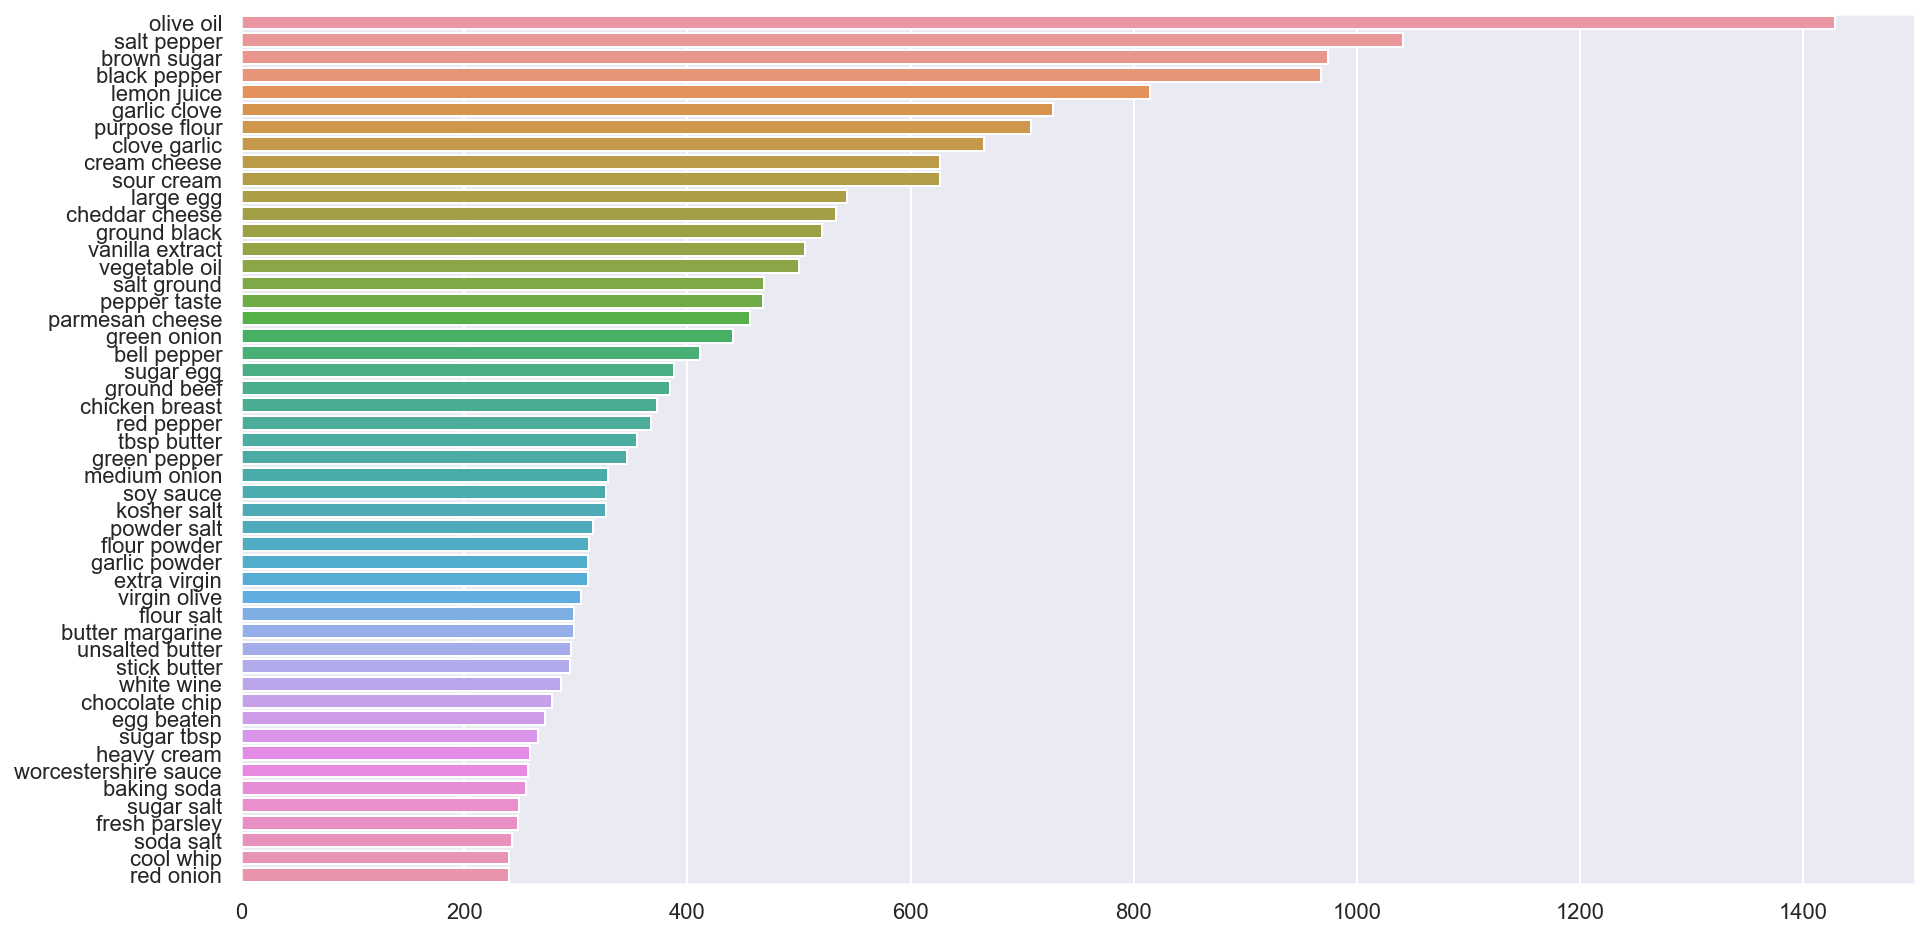

In [291]:
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

In [292]:
top_n_trigrams = get_top_ngram(df_sample['clean_ingredients'],3)

<AxesSubplot:>

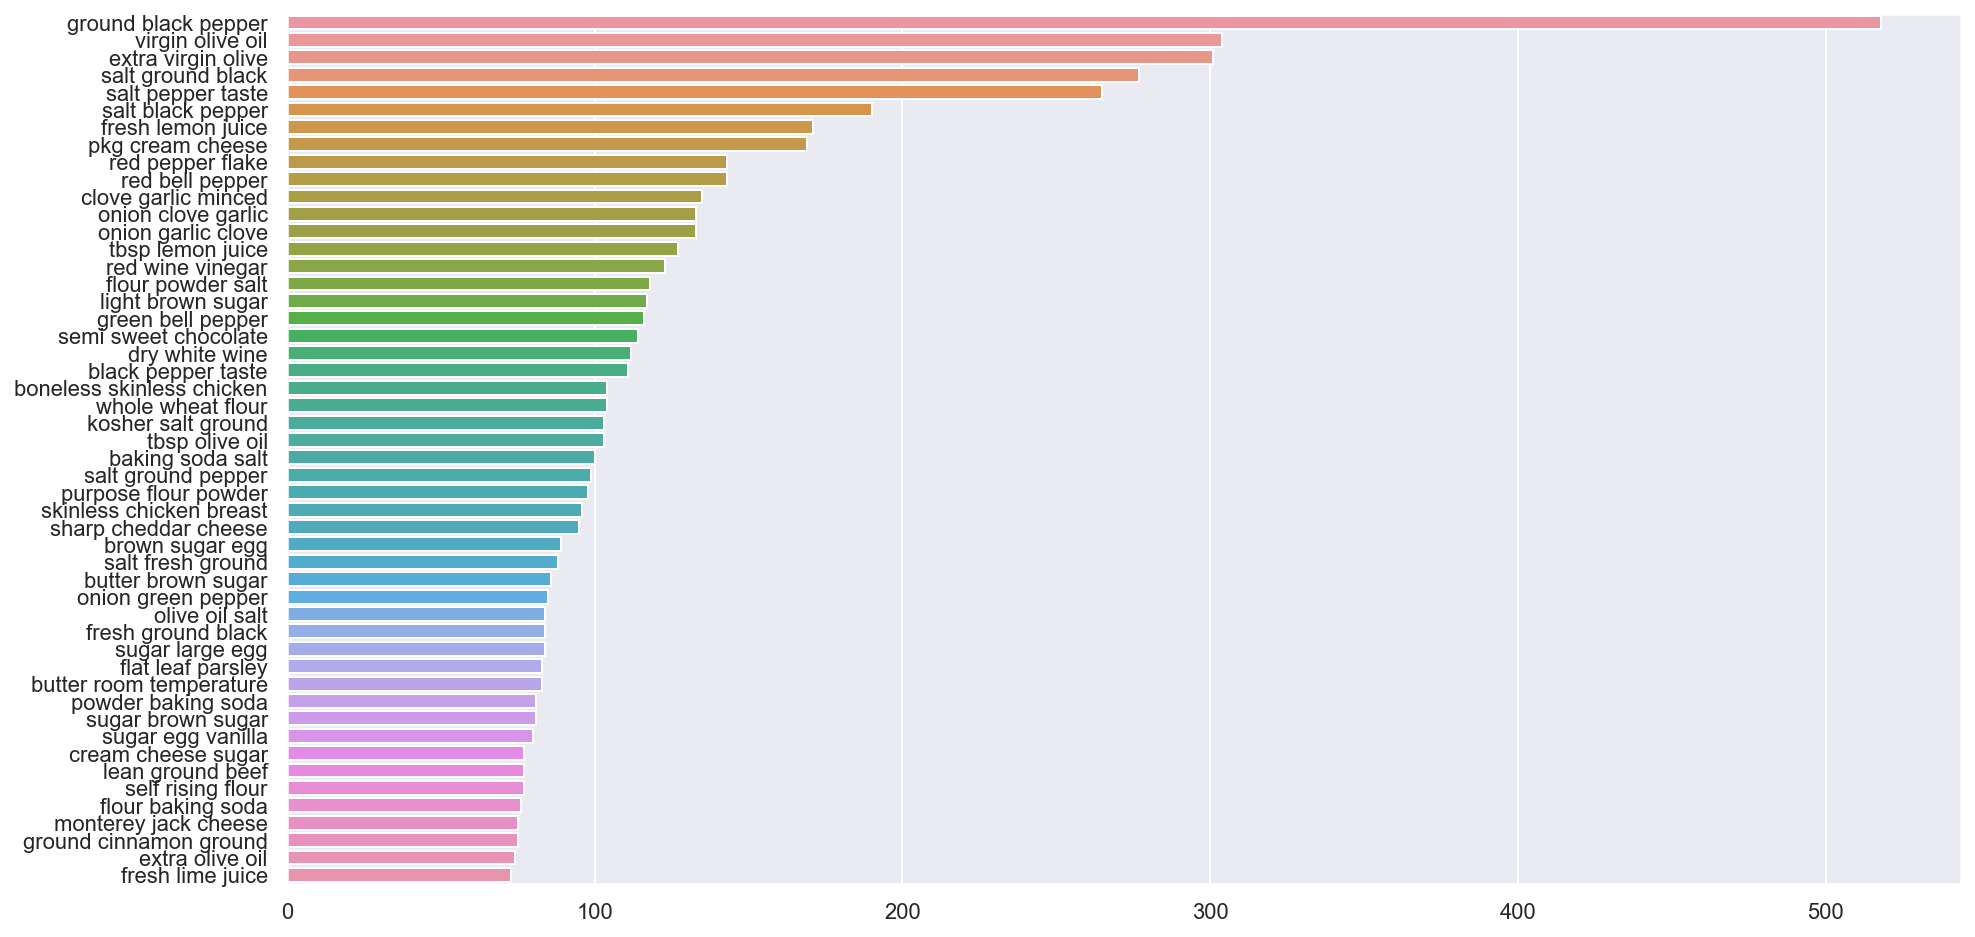

In [293]:
x,y=map(list,zip(*top_n_trigrams))
sns.barplot(x=y,y=x)

#### Notes:
Below are different POS tagging implementations to compare and identify if one functioned better than TextBlob. They varied some, but similarly mislabeled some words.

In [225]:
text = nltk.word_tokenize(df_sample['directions'][0])

In [227]:
nltk.pos_tag(text)

[('[', 'NN'),
 ('``', '``'),
 ('In', 'IN'),
 ('a', 'DT'),
 ('large', 'JJ'),
 ('skillet', 'NN'),
 (',', ','),
 ('saute', 'VB'),
 ('the', 'DT'),
 ('onion', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('olive', 'JJ'),
 ('oil', 'NN'),
 ('.', '.'),
 ('``', '``'),
 (',', ','),
 ('``', '``'),
 ('When', 'WRB'),
 ('the', 'DT'),
 ('onion', 'NN'),
 ('is', 'VBZ'),
 ('just', 'RB'),
 ('tender', 'NN'),
 (',', ','),
 ('add', 'VB'),
 ('the', 'DT'),
 ('turmeric', 'JJ'),
 ('and', 'CC'),
 ('garam', 'JJ'),
 ('masala', 'NN'),
 ('and', 'CC'),
 ('cook', 'NN'),
 ('for', 'IN'),
 ('a', 'DT'),
 ('minute', 'NN'),
 ('.', '.'),
 ('``', '``'),
 (',', ','),
 ('``', '``'),
 ('Add', 'NNP'),
 ('water', 'NN'),
 ('and', 'CC'),
 ('vegetarian', 'JJ'),
 ('chicken', 'NN'),
 ('flavoring', 'NN'),
 (',', ','),
 ('then', 'RB'),
 ('diced', 'VBD'),
 ('eggplant', 'NN'),
 ('.', '.'),
 ('``', '``'),
 (',', ','),
 ('``', '``'),
 ('Cover', 'NNP'),
 ('and', 'CC'),
 ('cook', 'VB'),
 ('until', 'IN'),
 ('eggplant', 'JJ'),
 ('is', 'VBZ'),
 ('tende

In [228]:
df_sample['directions'][0]

'["In a large skillet, saute the onion in the olive oil.", "When the onion is just tender, add the turmeric and garam masala and cook for a minute.", "Add water and vegetarian chicken flavoring, then diced eggplant.", "Cover and cook until eggplant is tender.", "Add winter squash and salt, and additional water if necessary.", "Stir.", "When heated through and liquid is reduced to about half a cup, add coconut milk and stir thoroughly.", "Remove from heat and serve over brown rice."]'

In [229]:
import spacy

In [232]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(df_sample['directions'][0])

In [235]:
print(f"{'text':{8}} {'POS':{6}} {'TAG':{6}} {'Dep':{6}} {'POS explained':{20}} {'tag explained'} ")
for token in doc:
    print(f'{token.text:{8}} {token.pos_:{6}} {token.tag_:{6}} {token.dep_:{6}} {spacy.explain(token.pos_):{20}} {spacy.explain(token.tag_)}')


text     POS    TAG    Dep    POS explained        tag explained 
[        PUNCT  -LRB-  punct  punctuation          left round bracket
"        PUNCT  ``     punct  punctuation          opening quotation mark
In       ADP    IN     prep   adposition           conjunction, subordinating or preposition
a        DET    DT     det    determiner           determiner
large    ADJ    JJ     amod   adjective            adjective
skillet  NOUN   NN     pobj   noun                 noun, singular or mass
,        PUNCT  ,      punct  punctuation          punctuation mark, comma
saute    VERB   VB     pcomp  verb                 verb, base form
the      DET    DT     det    determiner           determiner
onion    NOUN   NN     dobj   noun                 noun, singular or mass
in       ADP    IN     prep   adposition           conjunction, subordinating or preposition
the      DET    DT     det    determiner           determiner
olive    NOUN   NN     amod   noun                 noun, singular o